In [1]:
import json 
import os 
import pandas as pd 
import numpy as np 
import analysis_utils
import importlib 
from matplotlib.pylab import plt 
import importlib
import model_utils
import utils
from matplotlib.pylab import plt 
import seaborn as sns 
import numpy as np
import vis_utils
import model_evaluation
import os
import json
import pandas as pd
import analysis_utils
import random
from scipy.stats import pearsonr, spearmanr
from model_utils import WorldModel
from scipy.stats import wasserstein_distance_nd


%matplotlib inline

In [2]:

'''
Point to various directories where models are and load in stimuli 
''' 


scenario_dir="olympics/scenarios/"
use_pilot_filtering=True
main_dir = "olympics_run/"
prompt_tag = "_condMulti_tug_of_war_jump_n_legged_race_"

n_queries = 8
query_order = ["skill-1", "skill-2", "skill-3", "latent-1", "latent-2", "latent-3", "new-1",  "new-2"]
query2order = {query: i+1 for i, query in enumerate(query_order)}
sports = ["tug-of-war","canoe-race"]#, "diving"]


importlib.reload(analysis_utils)

sorted_stimuli_ids, all_scenarios = analysis_utils.get_stimuli_ids(scenario_dir=scenario_dir, use_pilot_filtering=use_pilot_filtering)


SCENARIOS:  110


FILTERED SCENARIOS:  109


In [3]:
''' 
Load in the full written scenario
'''

stim2txt = {stim_id: "" for stim_id in sorted_stimuli_ids}
for stim_id in sorted_stimuli_ids: 
    if stim_id[0] == ".": stim_id = stim_id[1:]
    stim_file = f"olympics/scenarios/{stim_id}.txt"
    with open(stim_file, "r") as f: res = f.readlines()
    stim2txt[stim_id] = res

In [4]:
'''
Load in human data
'''

data_pth = "multiclick_scenario_res.json"

with open(data_pth, "r") as f:
    human_data = json.load(f)
human_data

{'canoe-race_effort_team-diverse-17': [{'query1': [95, 93, 90, 87, 85],
   'query2': [78, 76, 73, 65, 62],
   'query3': [25, 22, 17, 14, 20],
   'query4': [87, 90, 85, 81, 77],
   'query5': [88, 92, 86, 82, 79],
   'query6': [53, 50, 45, 41, 48]},
  {'query1': [100, 96, 92, 86, 82],
   'query2': [69, 74, 78, 83, 86],
   'query3': [35, 39, 44, 51, 55],
   'query4': [70, 76, 84, 92, 98],
   'query5': [71, 77, 83, 90, 94],
   'query6': [46, 52, 58, 41, 34]},
  {'query1': [65, 73, 79, 84, 75],
   'query2': [65, 71, 77, 80, 73],
   'query3': [51, 42, 46, 57, 49],
   'query4': [66, 71, 76, 53, 61],
   'query5': [57, 63, 69, 75, 80],
   'query6': [59, 66, 71, 74, 62]},
  {'query1': [100, 36, 50, 85, 68],
   'query2': [100, 34, 53, 68, 82],
   'query3': [100, 1, 32, 50, 14],
   'query4': [100, 38, 60, 73, 89],
   'query5': [100, 37, 63, 76, 88],
   'query6': [100, 1, 25, 50, 76]}],
 'tug-of-war_effort_team-confounded-opponent-12': [{'query1': [5,
    12,
    19,
    27,
    49],
   'query2': [

In [5]:
stim_stubs = list(human_data.keys())
stim_stubs

['canoe-race_effort_team-diverse-17',
 'tug-of-war_effort_team-confounded-opponent-12',
 'canoe-race_effort_team-explain-away-confounded-opponent-partner',
 'tug-of-war_effort_team-confounded-partner-10',
 'canoe-race_effort_team-strong-indirect-14',
 'canoe-race_effort_individ-explain-away-bonus2',
 'canoe-race_effort_team-explain-away-11',
 'tug-of-war_effort_team-diverse-18',
 'canoe-race_effort_team-round-robin-20',
 'canoe-race_effort_team-round-robin-19',
 'tug-of-war_effort_team-explain-away-13',
 'tug-of-war_effort_individ-strong-indirect-4',
 'tug-of-war_effort_individ-explain-away-bonus',
 'canoe-race_effort_individ-diverse-7',
 'tug-of-war_effort_individ-explain-away-bonus3',
 'tug-of-war_effort_individ-explain-away-91012',
 'canoe-race_effort_team-weak-indirect-15',
 'tug-of-war_effort_team-explain-away-diverse-confounded-partner']

In [19]:
from optax import chain
import bkrd_theories

importlib.reload(utils)
importlib.reload(bkrd_theories)

sport = 'canoe-race'
stim_tag = 'team-explain-away-11' #check_stim.split("_")[2]
stim_tag = 'individ-diverse-7'
# stim_tag = 'individ-explain-away-bonus2'
# sport = 'tug-of-war'
# stim_tag = 'individ-explain-away-bonus'
# stim_tag = "team-explain-away-confounded-opponent"
translations = bkrd_theories.TRANSLATIONS[stim_tag]


n_chains = 10#20
n_draw = 5
n_samps = 10 # num samps (individs?) per chain (check)
burn_in = 1000
slop_theory_prob = 0.5

all_query_samps = []
all_chain_res = []


for chain_idx in range(n_chains): 
    if chain_idx % 5 == 0: print("on chain idx: ", chain_idx)
    try: 
        
        # choose a theory 
        
        # if np.random.rand() < slop_theory_prob: 
        #     theory_code = bkrd_theories.SLOP_THEORY_CODE
        # else: 
        #     theory_code = bkrd_theories.LATENT_THEORY_CODE
        
        theory_code = bkrd_theories.SPORT_MODELS[sport]
            
        theory_code = theory_code.replace("<CONDITION-QUERY-TRANSLATIONS>", translations)

        ppl_res = utils.run_webppl(theory_code, tmp_file="temp.wppl", timeout=90, append_utilities=True)
        all_chain_res.append(ppl_res)
        samples = eval(ppl_res[1])
        samples = np.array(samples)
        for _ in range(n_samps):
            idxs = np.arange(burn_in, len(samples))
            samp_idxs = np.random.choice(idxs, n_draw, replace=False) # check replacement
            samps = samples[samp_idxs]
            query_samps = {f"query{idx+1}": 0 for idx in range(n_queries)}
            for s in samps: 
                for q, x in s['value'].items(): 
                    query_idx = int(q.split("query")[-1])
                    if query_idx >= 7: 
                    
                        if x is True: query_samps[q] += 1
                        
                    if query_idx <= 3: 
                        
                        query_samps[q] += x / 100
                        
                    else: 
                        
                        query_samps[q] += x
                        
            query_samps = {k: (v / n_draw) * 100 for k, v in query_samps.items()}
            all_query_samps.append(query_samps)
    except Exception as e:
        print("ERROR: ", e) 
        continue

on chain idx:  0
on chain idx:  5


In [20]:
n_draw = 5
n_samps = 1 # num samps (individs?) per chain (check)
burn_in = 1000

all_query_samps = []

for ppl_res in all_chain_res: 
    samples = eval(ppl_res[1])
    samples = np.array(samples)
    for _ in range(n_samps):
        idxs = np.arange(burn_in, len(samples))
        samp_idxs = np.random.choice(idxs, n_draw, replace=False) # check replacement
        samps = samples[samp_idxs]
        query_samps = {f"query{idx+1}": [] for idx in range(6)}#range(n_queries)}
        for s in samps: 
            for q, x in s['value'].items(): 
                query_idx = int(q.split("query")[-1])
                if query_idx >= 7: continue
                # if query_idx >= 7: 
                
                #     if x is True: query_samps[q] += 1
                    
                if query_idx <= 3: 
                    
                    query_samps[q].append(x)
                    
                else: 
                    
                    query_samps[q].append(x * 100)
        query_samps = {k: v for k, v in query_samps.items()} #{k: (v / n_draw) * 100 for k, v in query_samps.items()}
        all_query_samps.append(query_samps)

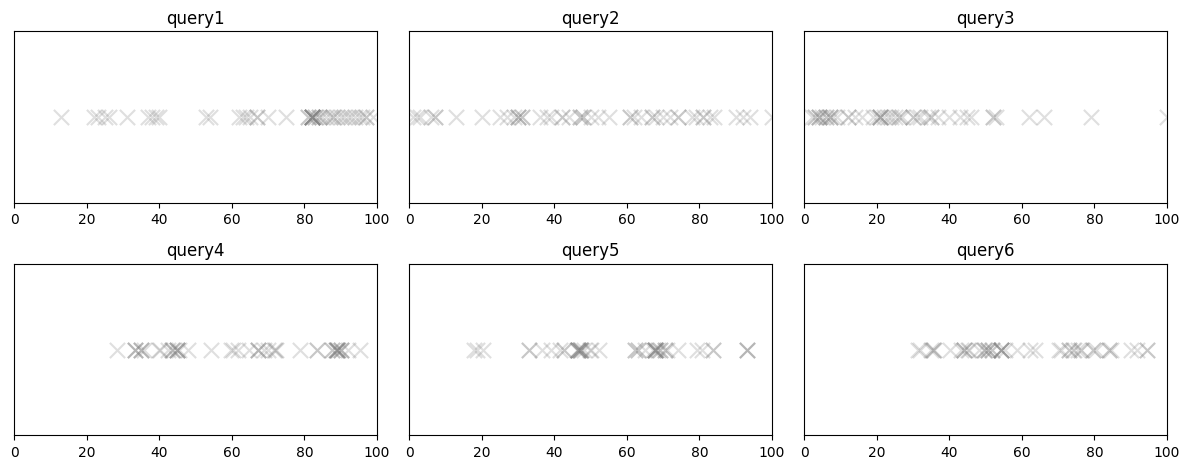

In [18]:
save_dir = "viz/"
pdf_filename = "stim_resps_multi_click.pdf"
save_pths = []
alpha = 0.2


fig, axes = plt.subplots(2, 3, figsize=(12, 5))
# fig.suptitle(f'{scenario}', fontsize=16)
axes = axes.flatten()  
#res = scenario_data[scenario]
for queries in all_query_samps:
    for query, values_list in queries.items():
        query_idx = int(query.split("query")[-1])
        ax = axes[query_idx-1]
        ax.scatter(values_list, [1]*len(values_list), marker='x', color='grey', alpha=0.25,
                    s=120)
for i in range(6): 
    ax = axes[i]
    ax.set_xlim(0, 100)
    ax.set_title(f"query{i+1}")
    ax.set_xticks(np.arange(0, 101, 20))
    ax.set_yticks([])
    
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()
# pth = f"{save_dir}/{scenario}.png"
# plt.savefig(pth)
# save_pths.append(pth)
# plt.close()

# pngs_to_pdf(save_dir, output_pth=pdf_filename)

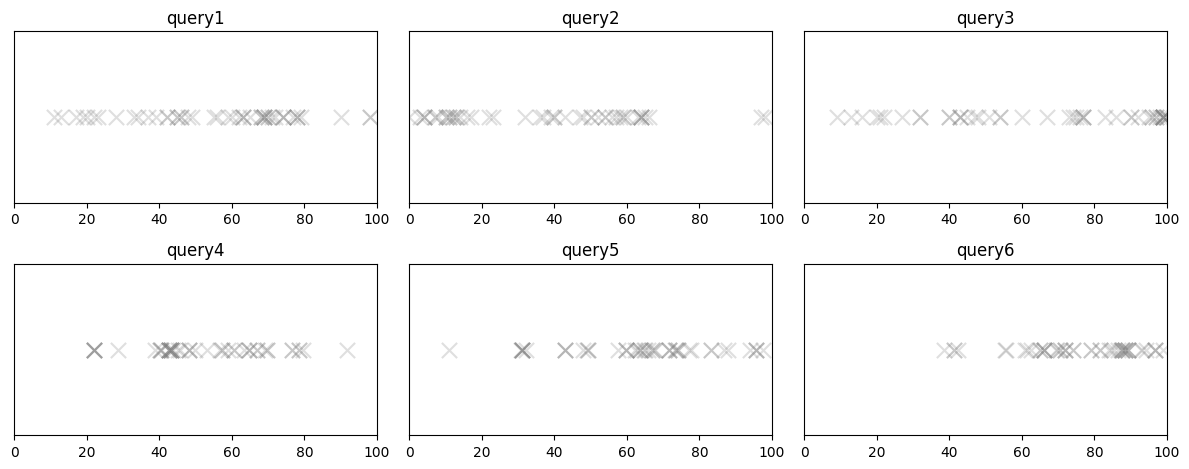

In [8]:
save_dir = "viz/"
pdf_filename = "stim_resps_multi_click.pdf"
save_pths = []
alpha = 0.2


fig, axes = plt.subplots(2, 3, figsize=(12, 5))
# fig.suptitle(f'{scenario}', fontsize=16)
axes = axes.flatten()  
#res = scenario_data[scenario]
for queries in all_query_samps:
    for query, values_list in queries.items():
        query_idx = int(query.split("query")[-1])
        ax = axes[query_idx-1]
        ax.scatter(values_list, [1]*len(values_list), marker='x', color='grey', alpha=0.25,
                    s=120)
for i in range(6): 
    ax = axes[i]
    ax.set_xlim(0, 100)
    ax.set_title(f"query{i+1}")
    ax.set_xticks(np.arange(0, 101, 20))
    ax.set_yticks([])
    
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()
# pth = f"{save_dir}/{scenario}.png"
# plt.savefig(pth)
# save_pths.append(pth)
# plt.close()

# pngs_to_pdf(save_dir, output_pth=pdf_filename)

In [51]:
all_query_samps[0]

{'query1': [97, 78, 10, 17, 91],
 'query2': [38, 86, 13, 17, 77],
 'query3': [41, 99, 23, 44, 91],
 'query4': [0, 0, 100, 0, 0],
 'query5': [0, 100, 100, 0, 100],
 'query6': [100, 100, 100, 100, 100]}

In [48]:
all_query_samps

[{'query1': [97, 78, 10, 17, 91],
  'query2': [38, 86, 13, 17, 77],
  'query3': [41, 99, 23, 44, 91],
  'query4': [0, 0, 100, 0, 0],
  'query5': [0, 100, 100, 0, 100],
  'query6': [100, 100, 100, 100, 100]},
 {'query1': [74, 26, 45, 49, 93],
  'query2': [47, 13, 40, 36, 65],
  'query3': [97, 69, 84, 47, 95],
  'query4': [0, 0, 0, 100, 0],
  'query5': [0, 100, 100, 0, 100],
  'query6': [100, 100, 100, 100, 100]},
 {'query1': [92, 62, 15, 17, 90],
  'query2': [69, 55, 22, 5, 81],
  'query3': [89, 51, 8, 77, 98],
  'query4': [0, 100, 100, 0, 100],
  'query5': [100, 100, 100, 100, 100],
  'query6': [100, 100, 100, 100, 100]},
 {'query1': [13, 86, 62, 74, 61],
  'query2': [44, 67, 12, 37, 67],
  'query3': [24, 68, 86, 77, 44],
  'query4': [0, 100, 0, 100, 100],
  'query5': [100, 100, 100, 100, 100],
  'query6': [100, 100, 0, 100, 100]},
 {'query1': [82, 87, 92, 49, 45],
  'query2': [70, 36, 94, 55, 45],
  'query3': [95, 73, 100, 97, 98],
  'query4': [0, 0, 100, 100, 0],
  'query5': [100, 10

In [38]:
samps

array([{'value': {'query1': 82, 'query2': 86, 'query3': 55, 'query4': False, 'query5': True, 'query6': True, 'query7': True, 'query8': True}}],
      dtype=object)

In [39]:
all_query_samps

[{'query1': 39.0,
  'query2': 9.0,
  'query3': 49.0,
  'query4': 0.0,
  'query5': 100.0,
  'query6': 0.0,
  'query7': 200.0,
  'query8': 0.0},
 {'query1': 12.0,
  'query2': 24.0,
  'query3': 38.0,
  'query4': 100.0,
  'query5': 0.0,
  'query6': 100.0,
  'query7': 0.0,
  'query8': 0.0},
 {'query1': 67.0,
  'query2': 67.0,
  'query3': 37.0,
  'query4': 100.0,
  'query5': 0.0,
  'query6': 100.0,
  'query7': 0.0,
  'query8': 200.0},
 {'query1': 96.0,
  'query2': 41.0,
  'query3': 93.0,
  'query4': 0.0,
  'query5': 100.0,
  'query6': 100.0,
  'query7': 200.0,
  'query8': 200.0},
 {'query1': 74.0,
  'query2': 22.0,
  'query3': 48.0,
  'query4': 0.0,
  'query5': 100.0,
  'query6': 100.0,
  'query7': 0.0,
  'query8': 200.0},
 {'query1': 73.0,
  'query2': 61.0,
  'query3': 67.0,
  'query4': 100.0,
  'query5': 100.0,
  'query6': 100.0,
  'query7': 0.0,
  'query8': 0.0},
 {'query1': 44.0,
  'query2': 11.0,
  'query3': 76.0,
  'query4': 0.0,
  'query5': 100.0,
  'query6': 100.0,
  'query7': 200.0,

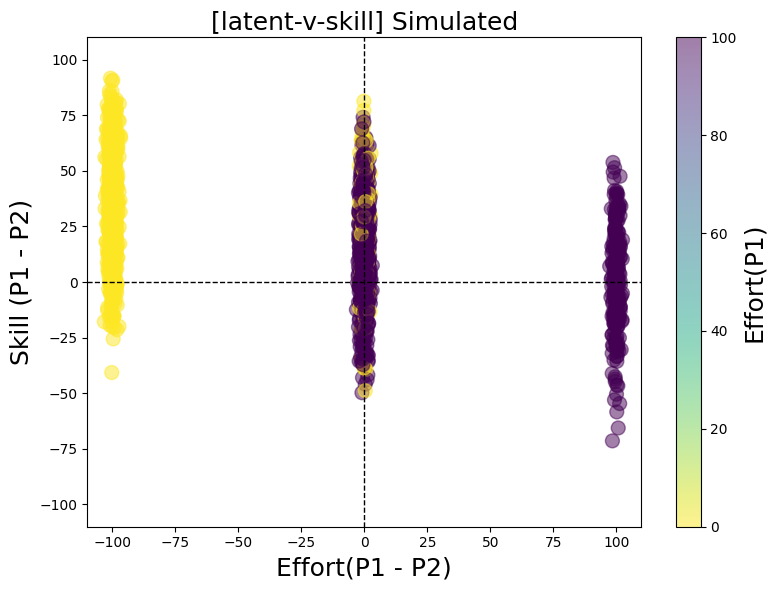

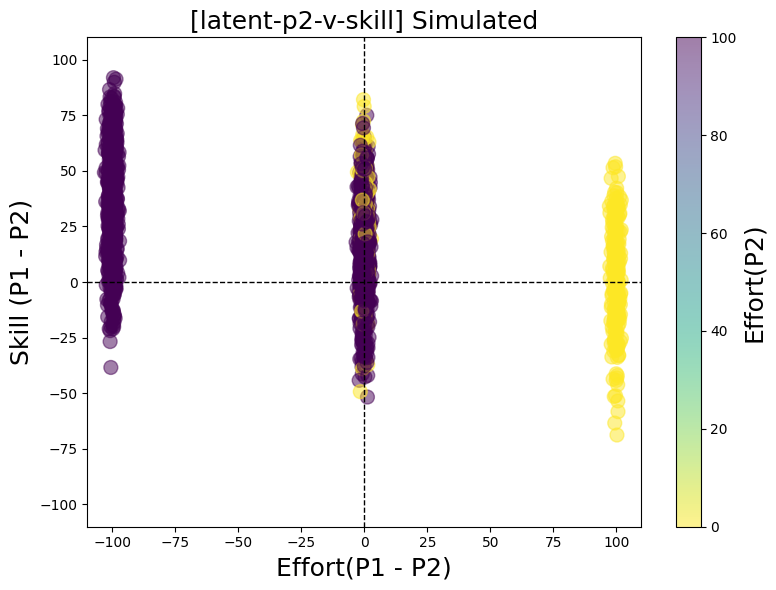

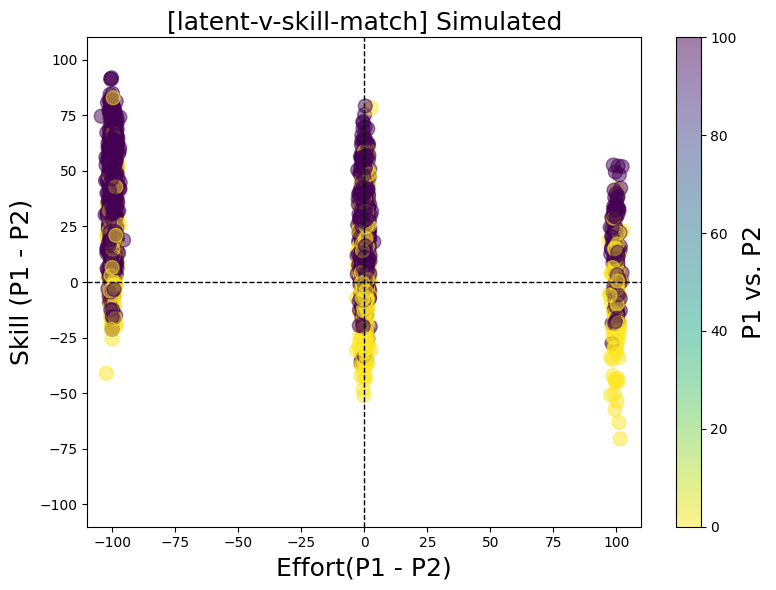

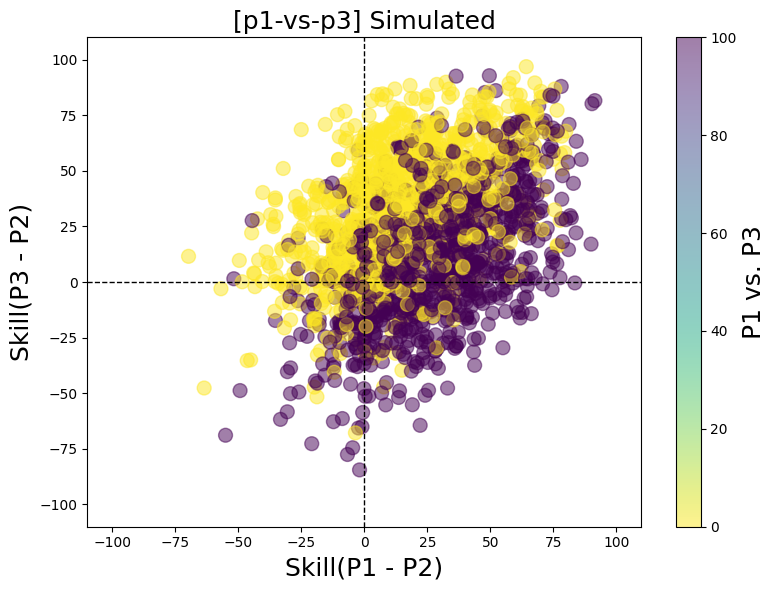

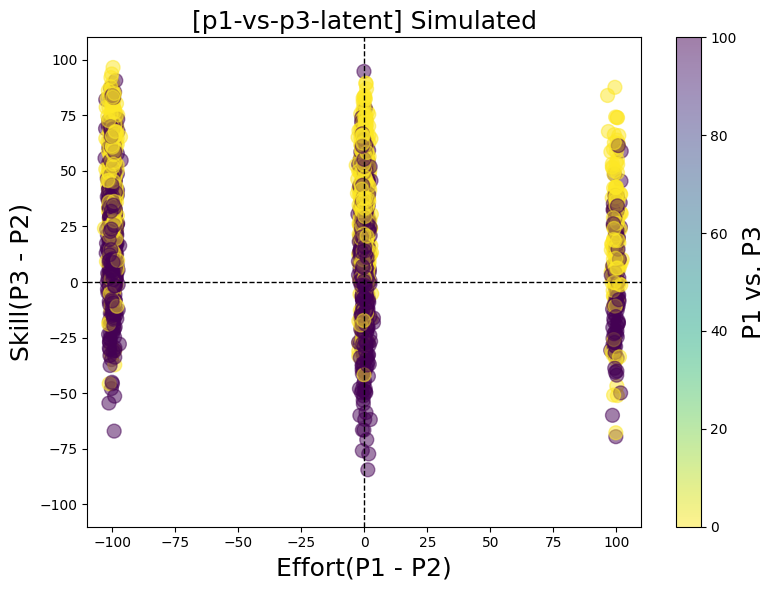

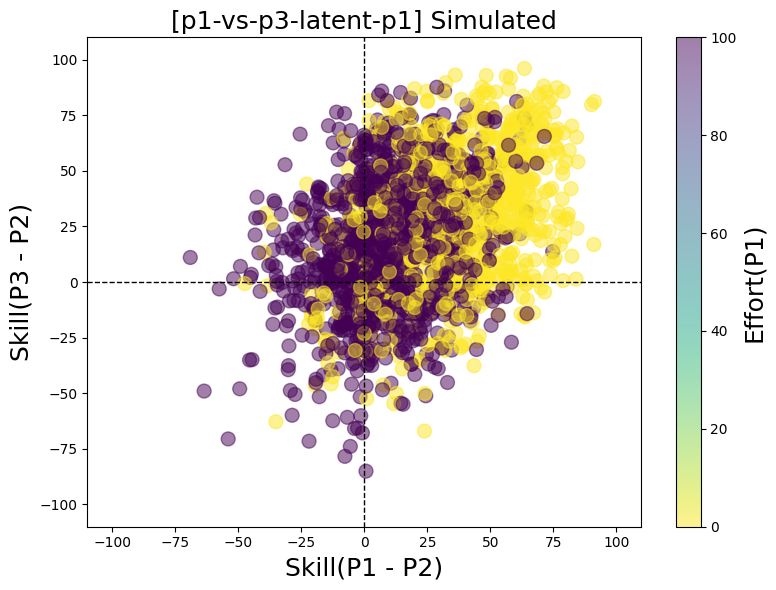

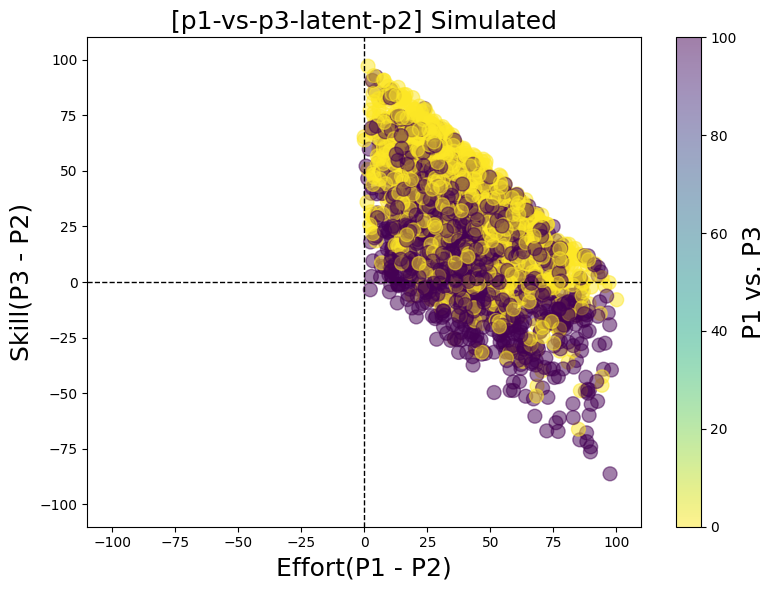

In [40]:
importlib.reload(analysis_utils)

scenario = f"{sport}_effort_{stim_tag}"

query_patterns = {
    
    "latent-v-skill": {
        "x_queries": ("query4", "query5"),
        "y_queries": ("query1", "query2"),
        "c_queries": ("query4",),
        "x_label": "Effort(P1 - P2)",
        "y_label": "Skill (P1 - P2)",
        "c_label": "Effort(P1)"
    },
    
     "latent-p2-v-skill": {
        "x_queries": ("query4", "query5"),
        "y_queries": ("query1", "query2"),
        "c_queries": ("query5",),
        "x_label": "Effort(P1 - P2)",
        "y_label": "Skill (P1 - P2)",
        "c_label": "Effort(P2)"
    },
     
    "latent-v-skill-match": {
        "x_queries": ("query4", "query5"),
        "y_queries": ("query1", "query2"),
        "c_queries": ("query7",),
        "x_label": "Effort(P1 - P2)",
        "y_label": "Skill (P1 - P2)",
        "c_label": "P1 vs. P2"
    },
    
    "p1-vs-p3": {
        "y_queries": ("query3", "query2"),
        "x_queries": ("query1", "query2"),
        "c_queries": ("query8",),
        "y_label": "Skill(P3 - P2)",
        "x_label": "Skill(P1 - P2)",
        "c_label": "P1 vs. P3"
    },
    
    "p1-vs-p3-latent": {
        "y_queries": ("query3", "query2"),
        "x_queries": ("query4", "query5"),
        "c_queries": ("query8",),
        "y_label": "Skill(P3 - P2)",
        "x_label": "Effort(P1 - P2)",
        "c_label": "P1 vs. P3"
    },
    
    "p1-vs-p3-latent-p1": {
        "y_queries": ("query3", "query2"),
        "x_queries": ("query1", "query2"),
        "c_queries": ("query4",),
        "y_label": "Skill(P3 - P2)",
        "x_label": "Skill(P1 - P2)",
        "c_label": "Effort(P1)"
    },
    
    "p1-vs-p3-latent-p2": {
        "y_queries": ("query3", "query2"),
        "x_queries": ("query2",),
        "c_queries": ("query8",),
        "y_label": "Skill(P3 - P2)",
        "x_label": "Effort(P1 - P2)",
        "c_label": "P1 vs. P3"
    },
    
    
    
}


show_llm = False

# TODO: add a cell that prints out the scenario

for i, (query_pattern_name, query_pattern) in enumerate(query_patterns.items()): 
    #if i > 0: continue
    analysis_utils.query_scatterplot(
        all_query_samps,
        x_queries=query_pattern["x_queries"], 
        y_queries=query_pattern["y_queries"], 
        c_queries=query_pattern["c_queries"], 
        x_label=query_pattern["x_label"], 
        y_label=query_pattern["y_label"],  
        c_label=query_pattern["c_label"], 
        title=f"[{query_pattern_name}] Simulated"
    )

    # variant = "implicit"
    # human_resps = [r for r in human_data[scenario]] # focus on implicit case?
    # analysis_utils.query_scatterplot(
    #     human_resps,
    #     x_queries=query_pattern["x_queries"], 
    #     y_queries=query_pattern["y_queries"], 
    #     c_queries=query_pattern["c_queries"], 
    #     x_label=query_pattern["x_label"], 
    #     y_label=query_pattern["y_label"],  
    #     c_label=query_pattern["c_label"], 
    #     title=f"[{query_pattern_name}] Human"
    # )

0.9989908241905904 0.9989974974990018


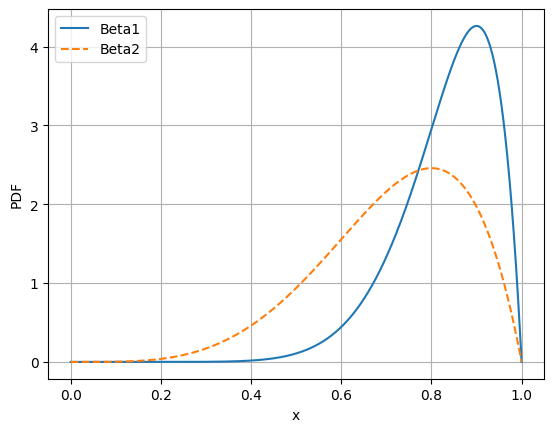

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Define the x values (probabilities)
x = np.linspace(0, 1, 1000)

# Beta distributions
beta1 = beta.pdf(x, 10, 2)
#beta1 = np.ones([len(beta1)]) - beta1
beta2 = beta.pdf(x, 5, 2)

print(np.mean(beta1), np.mean(beta2))

# Plot
plt.figure()#figsize=(8, 6))
plt.plot(x, beta1, label='Beta1')
plt.plot(x, beta2, label='Beta2', linestyle='--')
plt.xlabel('x')
plt.ylabel('PDF')
plt.legend()
plt.grid(True)
plt.show()


In [70]:
beta1.shape

(1000,)

(array([1.433e+03, 1.510e+02, 3.500e+01, 9.000e+00, 8.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([   7.218 ,  139.4798,  271.7416,  404.0034,  536.2652,  668.527 ,
         800.7888,  933.0506, 1065.3124, 1197.5742, 1329.836 ]),
 <BarContainer object of 10 artists>)

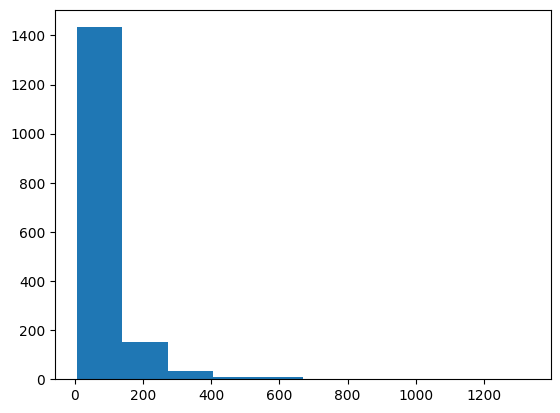

In [4]:
data_dir = "olympics/raw_data/"
participant_dfs = [pd.read_csv(f"{data_dir}{f}") for f in os.listdir(data_dir) if ".csv" in f]
times = []
comments = []
for df in participant_dfs:
    uid = df.prolific_id.iloc[0]
    resp_trials = df.loc[df.trial_type == "survey-html-form"]
    times.extend(list(resp_trials.rt))
    
    comments.append([uid, df.iloc[-1]["response"]])
times = [t / 1000 for t in times]
plt.hist(times)

In [18]:
np.mean(times)

np.float64(86.53691590493604)

In [13]:
np.mean(participant_dfs[0]["rt"])

np.float64(58522.0)

In [10]:
from importlib import metadata


fpth = "olympics/human_comments.csv"
metadata_df = {"uid": [], "strategy": []}

with open("olympics/participant_comments.txt", "w") as f: 
    for uid,r in comments: 
        try: 
            strategy = eval(r)["Q0"]
            metadata_df["uid"].append(uid)
            metadata_df["strategy"].append(strategy)
            f.write(f"UID: {uid}\nStrategy: {strategy}\n\n")
        except: continue 
        
pd.DataFrame.from_dict(metadata_df).to_csv(fpth)